In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import numpy as np
import pathlib
import random
import os
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow.keras.callbacks as keras_callbacks

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Importing Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pwd
!ls /content/drive/MyDrive/final_dataset

/content
HAM10000_images_part_1	HAM10000_images_part_2	HAM10000_metadata


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 192

# Path to directories
data_dir_part1 = "/content/drive/MyDrive/final_dataset/HAM10000_images_part_1"
data_dir_part2 = "/content/drive/MyDrive/final_dataset/HAM10000_images_part_2"
metadata_file = "/content/drive/MyDrive/final_dataset/HAM10000_metadata"

# Data Preparation

In [ ]:
# Function to load images and labels
def load_images_and_labels(data_dir, metadata_file):
    metadata_df = pd.read_csv(metadata_file)
    images = []
    labels = []
    for index, row in metadata_df.iterrows():
        img_path = os.path.join(data_dir, f"{row['image_id']}.jpg")
        if os.path.exists(img_path):
            images.append(img_path)
            labels.append(row['dx'])
    return images, labels

# Load images and labels from both parts
images_part1, labels_part1 = load_images_and_labels(data_dir_part1, metadata_file)
images_part2, labels_part2 = load_images_and_labels(data_dir_part2, metadata_file)

# Concatenate images and labels
images = images_part1 + images_part2
labels = labels_part1 + labels_part2

# Create DataFrame
df = pd.DataFrame({'image_path': images, 'label': labels})

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Splitting the data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Print the shapes of the datasets before balancing
print("Train set shape before balancing:", train_df.shape)

# Count the number of photos in each category before balancing
category_counts_before = train_df['label'].value_counts()
print("Number of photos in each category before balancing:")
print(category_counts_before)

Train set shape before balancing: (8051, 2)
Number of photos in each category before balancing:
5    5379
4     913
2     872
1     431
0     264
6     107
3      85
Name: label, dtype: int64


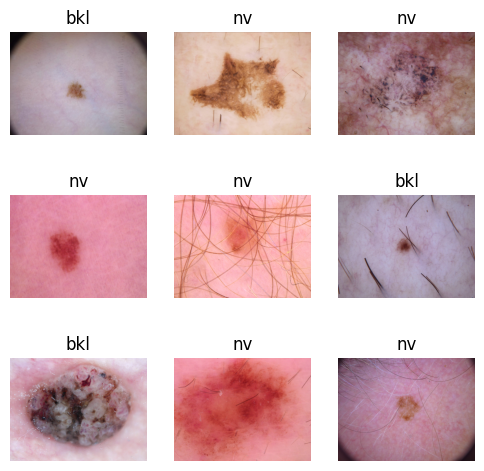

In [ ]:
# Randomly select 9 images
random_images = random.sample(images, 9)
random_labels = df.loc[df['image_path'].isin(random_images), 'label']

# Plot the images
plt.figure(figsize=(6, 6))
for i in range(len(random_images)):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img)
    plt.title(label_encoder.inverse_transform([random_labels.iloc[i]])[0])
    plt.axis("off")
plt.show()

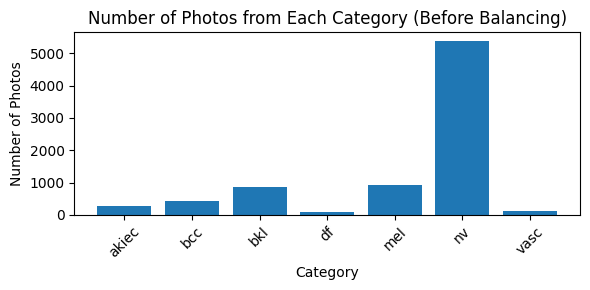

In [ ]:
# Plot the graph before balancing
plt.figure(figsize=(6, 3))
plt.bar(category_counts_before.index, category_counts_before.values)
plt.xlabel('Category')
plt.ylabel('Number of Photos')
plt.title('Number of Photos from Each Category (Before Balancing)')
plt.xticks(ticks=category_counts_before.index, labels=label_encoder.inverse_transform(category_counts_before.index), rotation=45)
plt.tight_layout()
plt.show()

As you can notice, difference between numbers of images for different categories are very big.

That's why we have used techniques of oversampling and undersampling simultaneously to create more balanced dataset that includes reasonable number of images for each category of skin lesion.

In [ ]:
# Calculate the target number of samples per class
target_samples_per_class = 1000

# Define a function to balance the dataset
def balance_dataset(df, target_samples_per_class):
    balanced_dfs = []

    # Iterate over each unique label
    for label in df['label'].unique():
        df_label = df[df['label'] == label]
        num_samples = len(df_label)

        # Oversample or undersample based on the number of samples
        if num_samples < target_samples_per_class:
            oversampled_df = df_label.sample(target_samples_per_class, replace=True, random_state=42)
        else:
            oversampled_df = df_label.sample(target_samples_per_class, random_state=42)

        balanced_dfs.append(oversampled_df)

    # Concatenate the balanced dataframes
    balanced_df = pd.concat(balanced_dfs)

    return balanced_df

# Balance the training dataset
train_balanced_df = balance_dataset(train_df, target_samples_per_class)

# Print the new shapes after balancing
print("\nTrain set shape after balancing:", train_balanced_df.shape)

# Count the number of photos in each category after balancing
category_counts_balanced = train_balanced_df['label'].value_counts()
print("Number of photos in each category after balancing:")
print(category_counts_balanced)



Train set shape after balancing: (7000, 2)
Number of photos in each category after balancing:
5    1000
2    1000
4    1000
0    1000
1    1000
3    1000
6    1000
Name: label, dtype: int64


Found 7000 validated image filenames.
Found 895 validated image filenames.
Found 995 validated image filenames.


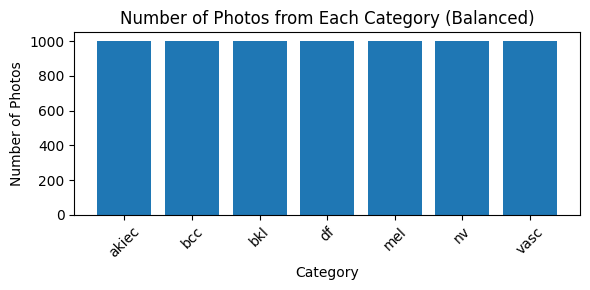

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create image generators from balanced dataset
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_balanced_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

# Plot the graph
plt.figure(figsize=(6, 3))
plt.bar(category_counts_balanced.index, category_counts_balanced.values)
plt.xlabel('Category')
plt.ylabel('Number of Photos')
plt.title('Number of Photos from Each Category (Balanced)')
plt.xticks(ticks=category_counts_balanced.index, labels=label_encoder.inverse_transform(category_counts_balanced.index), rotation=45)
plt.tight_layout()
plt.show()

Now, numbers of images representing different categories are equal.

To be more precise - they equally have 1000 images.

# Data augmentation

Found 8051 validated image filenames.


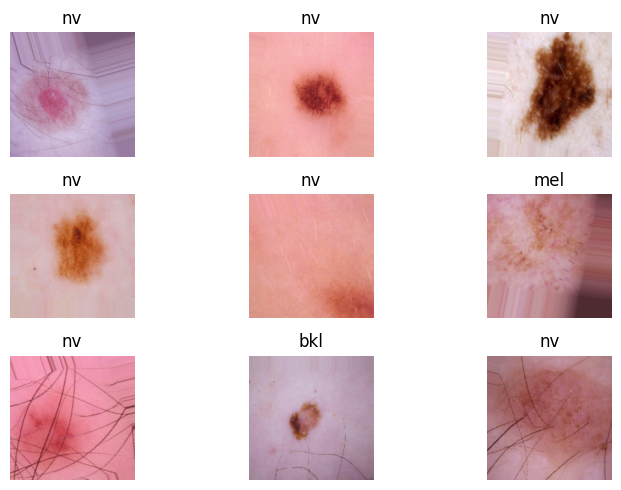

In [ ]:
# Define ImageDataGenerator for data augmentation
augmentation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create image generators with augmentation for training
train_generator_augmented = augmentation_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True,
    seed=42
)

# Example usage of the augmented generators
images_augmented, labels_augmented = next(train_generator_augmented)
plt.figure(figsize=(8, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # Ensure the pixel values are in the correct range
    plt.imshow(images_augmented[i] / 255)  # Rescale pixel values to [0, 1]
    plt.title(label_encoder.classes_[int(labels_augmented[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Training and Evaluating a Model with Regular Data

In [ ]:
#   CNN model suitable for skin lesion classification.
#   Parameters: input_shape (tuple): Shape of the input images (e.g., (192, 192, 3) for 192x192 RGB images).
#   Returns: model (Sequential): CNN model.


def create_model(input_shape):
    model = Sequential([
        # Convolutional layers to extract features
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(0.25),  # Dropout to avoid overfitting

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(0.25),  # Dropout to avoid overfitting

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(0.25),  # Dropout to avoid overfitting

        Flatten(),  # Flatten the 3D feature maps to 1D for Dense layers
        Dense(256, activation='relu'),  # Dense layer to learn more complex patterns
        BatchNormalization(),  # Batch normalization for training stability
        Dropout(0.4),  # Dropout to avoid overfitting

        Dense(128, activation='relu'),  # Another Dense layer
        BatchNormalization(),  # Batch normalization for training stability
        Dropout(0.4),  # Dropout to avoid overfitting

        Dense(7, activation='softmax')  # Output layer with 7 classes
    ])

    return model

Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 2.1978 - accuracy: 0.2384
Epoch 1: val_loss improved from inf to 1.29954, saving model to best_model.keras
219/219 [==============================] - 92s 403ms/step - loss: 2.1978 - accuracy: 0.2384 - val_loss: 1.2995 - val_accuracy: 0.4849
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 1.8762 - accuracy: 0.2817
Epoch 2: val_loss did not improve from 1.29954
219/219 [==============================] - 88s 403ms/step - loss: 1.8762 - accuracy: 0.2817 - val_loss: 1.6172 - val_accuracy: 0.6223
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 1.7203 - accuracy: 0.3136
Epoch 3: val_loss did not improve from 1.29954
219/219 [==============================] - 89s 405ms/step - loss: 1.7203 - accuracy: 0.3136 - val_loss: 1.3958 - val_accuracy: 0.3922
Epoch 4/30
219/219 [==============================] - ETA: 0s - loss: 1.6674 - accuracy: 0.3344
Epoch 4: val_loss did not improve from 

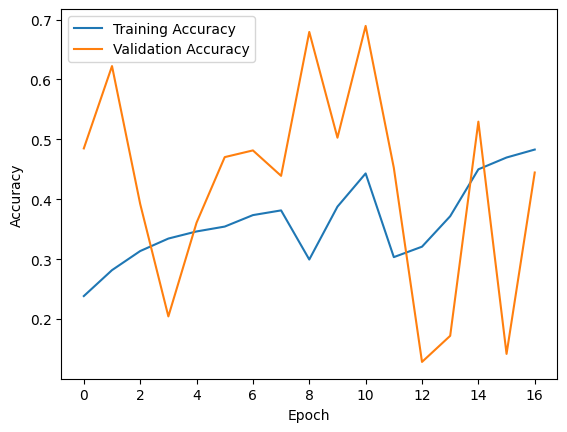

In [ ]:
# Create the CNN model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = create_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks for model checkpoints and early stopping
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Accuracy:", test_accuracy)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

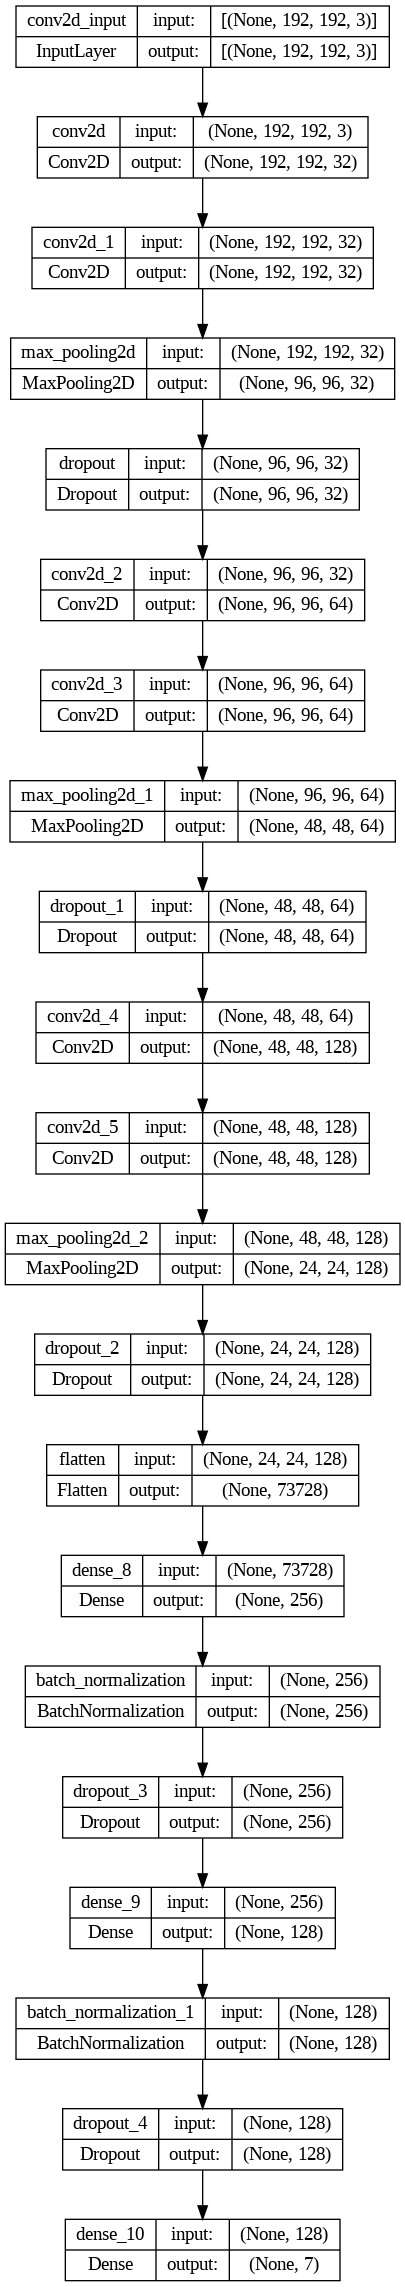

In [ ]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = create_model(input_shape)
keras.utils.plot_model(model, "m1.png", show_shapes=True)

In [ ]:
model.summary()

As you can see from the MatPlotLib graph above, training accuracy is starting from very low value and increasing steadily, until it reaches the point when the value is little above 0.5, which is not much better than flipping a coin. On top of that, evaluation accuracy is pretty much random, which is not a good sign.

Therefore, to fix this problem, we are going to apply augmented data to train our model.

# Training and Evaluating a Model with Augmented Data

Epoch 1/30
252/252 [==============================] - ETA: 0s - loss: 1.7255 - accuracy: 0.4647
Epoch 1: val_loss improved from inf to 2.71523, saving model to best_model_augmented.keras
252/252 [==============================] - 2716s 11s/step - loss: 1.7255 - accuracy: 0.4647 - val_loss: 2.7152 - val_accuracy: 0.6961
Epoch 2/30
252/252 [==============================] - ETA: 0s - loss: 1.1580 - accuracy: 0.6121
Epoch 2: val_loss improved from 2.71523 to 1.85642, saving model to best_model_augmented.keras
252/252 [==============================] - 2488s 10s/step - loss: 1.1580 - accuracy: 0.6121 - val_loss: 1.8564 - val_accuracy: 0.6961
Epoch 3/30
252/252 [==============================] - ETA: 0s - loss: 1.0825 - accuracy: 0.6282
Epoch 3: val_loss improved from 1.85642 to 1.78840, saving model to best_model_augmented.keras
252/252 [==============================] - 2516s 10s/step - loss: 1.0825 - accuracy: 0.6282 - val_loss: 1.7884 - val_accuracy: 0.6961
Epoch 4/30
252/252 [=========

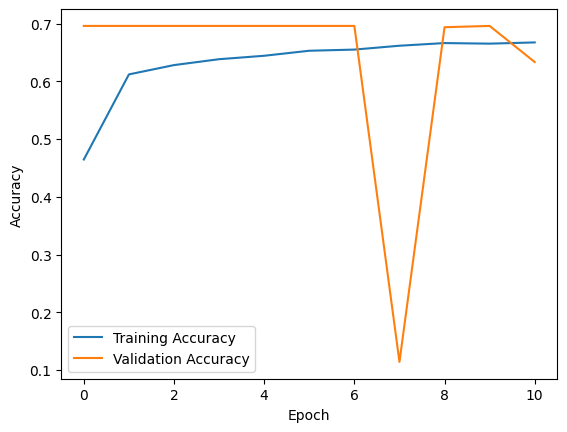

In [ ]:
# Create the new CNN model for augmented dataset
input_shape = (IMG_SIZE, IMG_SIZE, 3)  # Target size of images after augmentation
model_augmented = create_model(input_shape)

# Compile the model
model_augmented.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Define callbacks for model checkpoints and early stopping
checkpoint = ModelCheckpoint('best_model_augmented.keras', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Train the model
history_augmented = model_augmented.fit(
    train_generator_augmented,
    steps_per_epoch=len(train_generator_augmented),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model_augmented.evaluate(test_generator, steps=len(test_generator))
print("Test Accuracy:", test_accuracy)

# Plot training history
plt.plot(history_augmented.history['accuracy'], label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model trained on augmented data has shown itself to be more precise and stable compared to previous one, although there is a moment in training where validation accuracy dips down deeply.

Overall, current model is more stable, however final results on test accuracy is not very different from the previous one.

So, to achieve a maximum value of accuracy, we will try using transfer learning in the next stage.

# Using Existing Model (Transfer Learning)

Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 1.1053 - accuracy: 0.5947
Epoch 1: val_loss improved from inf to 1.10755, saving model to best_model.keras
219/219 [==============================] - 349s 2s/step - loss: 1.1053 - accuracy: 0.5947 - val_loss: 1.1075 - val_accuracy: 0.5777
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.7700
Epoch 2: val_loss improved from 1.10755 to 0.98745, saving model to best_model.keras
219/219 [==============================] - 303s 1s/step - loss: 0.6657 - accuracy: 0.7700 - val_loss: 0.9875 - val_accuracy: 0.6313
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.8377
Epoch 3: val_loss improved from 0.98745 to 0.91784, saving model to best_model.keras
219/219 [==============================] - 358s 2s/step - loss: 0.4855 - accuracy: 0.8377 - val_loss: 0.9178 - val_accuracy: 0.6793
Epoch 4/30
219/219 [==============================] - ETA: 0s - l

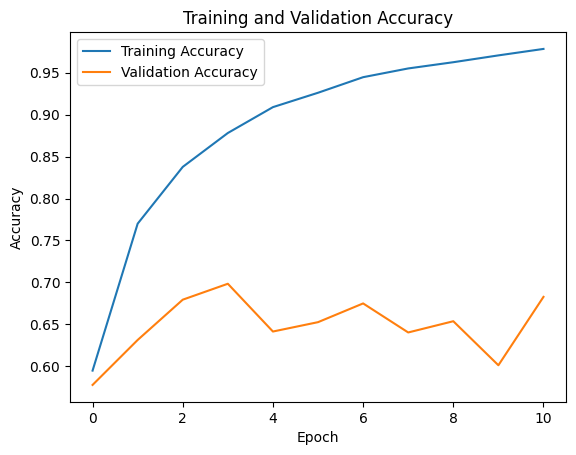

In [ ]:
from tensorflow import keras

# Load the MobileNetV2 pre-trained model without the top classification layers
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
)

# Freeze the pre-trained layers
base_model.trainable = False

# Add classification layers on top of the pre-trained model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)  # Assuming 7 classes

# Create the transfer learning model
transfer_model = keras.Model(inputs, outputs)

# Compile the model
transfer_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks for model checkpoints and early stopping
checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1)
early_stopping = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

# Train the model
history = transfer_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = transfer_model.evaluate(test_generator, steps=len(test_generator))
print("Test Accuracy:", test_accuracy)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

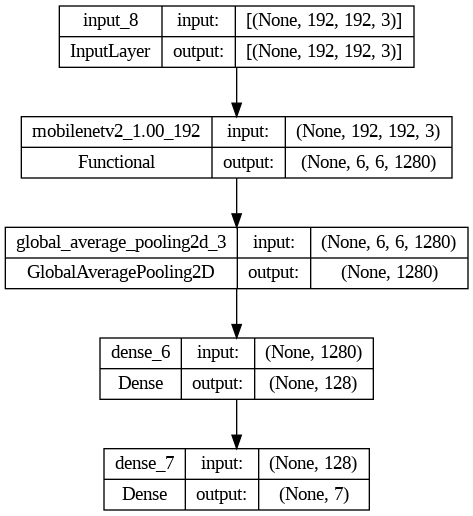

In [ ]:
keras.utils.plot_model(transfer_model, "m2.png", show_shapes=True)

# Converting Model and Downloading

In [ ]:
!pip install tensorflowjs

In [ ]:
# Save the model in .keras format
transfer_model.save('transfer_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!tensorflowjs_converter --input_format keras transfer_model.h5 tfjs_model

2024-03-06 09:15:16.393208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 09:15:16.393279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 09:15:16.395517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 09:15:18.340962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import shutil

shutil.move('/content/tfjs_model', '/content/drive/MyDrive/tfjs_model')

'/content/drive/MyDrive/tfjs_model'